# ResNet50

Defines a custom ResNet-50 model class in PyTorch for 20-class classification.
It builds the full ResNet-50 architecture using Bottleneck blocks, applies custom weight initialization, and defines the forward pass to process input images through convolutional, residual, pooling, and fully connected layers.

In [1]:
import torch
import torch.nn as nn
from torchvision.models.resnet import Bottleneck

class ResNet50(nn.Module):
    def __init__(self, num_classes=20):  # use 20 for your case
        super(ResNet50, self).__init__()
        self.inplanes = 64
        self.has_printed_input_shape = False
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # FC layer output set to 1000 to match pretrained weights
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        if not hasattr(self, 'has_printed_input_shape'):
          print(f"Input to model: {x.shape}")
          self.has_printed_input_shape = True
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Print Parameters Per Layer

In [2]:
model = ResNet50(num_classes=20)
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

Trainable parameters:
conv1.weight: 9408 parameters
bn1.weight: 64 parameters
bn1.bias: 64 parameters
layer1.0.conv1.weight: 4096 parameters
layer1.0.bn1.weight: 64 parameters
layer1.0.bn1.bias: 64 parameters
layer1.0.conv2.weight: 36864 parameters
layer1.0.bn2.weight: 64 parameters
layer1.0.bn2.bias: 64 parameters
layer1.0.conv3.weight: 16384 parameters
layer1.0.bn3.weight: 256 parameters
layer1.0.bn3.bias: 256 parameters
layer1.0.downsample.0.weight: 16384 parameters
layer1.0.downsample.1.weight: 256 parameters
layer1.0.downsample.1.bias: 256 parameters
layer1.1.conv1.weight: 16384 parameters
layer1.1.bn1.weight: 64 parameters
layer1.1.bn1.bias: 64 parameters
layer1.1.conv2.weight: 36864 parameters
layer1.1.bn2.weight: 64 parameters
layer1.1.bn2.bias: 64 parameters
layer1.1.conv3.weight: 16384 parameters
layer1.1.bn3.weight: 256 parameters
layer1.1.bn3.bias: 256 parameters
layer1.2.conv1.weight: 16384 parameters
layer1.2.bn1.weight: 64 parameters
layer1.2.bn1.bias: 64 parameters
laye

# Visual Summary

In [3]:
pip install torchsummary

In [4]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # make sure model is on GPU

summary(model, input_size=(3, 256, 256), device="cuda")  # tell summary to use cuda too


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# Load Pretrained Weights

Loads pretrained ResNet-50 weights from ImageNet into a custom ResNet50 model designed for 20 classes.
It excludes the final fully connected (fc) layer during loading to avoid size mismatch, so that only the feature extractor layers are initialized with pretrained weights.

In [5]:
import torch
from torchvision import models
from torchvision.models import ResNet50_Weights

# 1. Create your ResNet50 model with num_classes=20
model = ResNet50(num_classes=20)

# 2. Load official pretrained model
pretrained = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# 3. Get pretrained state_dict
pretrained_dict = pretrained.state_dict()
model_dict = model.state_dict()

# 4. Filter out fc layer (do not load fc.weight and fc.bias)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and not k.startswith('fc.')}

# 5. Update current model state_dict
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

print("Loaded pretrained weights except for fc layer!")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


Loaded pretrained weights except for fc layer!


# Script to structure training data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the dataset

In [7]:
#unzip the files

import zipfile
import os

# Unzip train
train_zip = "/content/drive/MyDrive/DATA255_Assignment3/imagenet_train.zip"
val_zip = "/content/drive/MyDrive/DATA255_Assignment3/imagenet_val.zip"

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/train")

with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/val")


Reorganizes validation images into class-specific folders based on a mapping file (imagenet_val.txt).
It reads filenames and class IDs, creates folders for each class, and moves each image from a flat directory into its corresponding class folder.

It prepares the validation dataset into a structured format required for ImageFolder loading in PyTorch.



In [8]:
import os
import shutil

val_txt = "/content/drive/MyDrive/DATA255_Assignment3/imagenet_val.txt"  # your val mapping file
val_input_folder = "/content/val/imagenet_val20"  # where flat JPEGs are
val_output_folder = "/content/val/imagenet_val20_structured"  # target structured folder

os.makedirs(val_output_folder, exist_ok=True)

with open(val_txt, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        filename, class_id = parts[0], parts[1]

        class_folder = os.path.join(val_output_folder, class_id)
        os.makedirs(class_folder, exist_ok=True)

        src = os.path.join(val_input_folder, filename)
        dst = os.path.join(class_folder, filename)

        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            print(f" Missing: {filename}")


# Data Augmentation and Normalization

Reads class names from the training file and renames validation folders to match the actual ImageNet class IDs.
It maps folders originally named 0, 1, 2, etc., into meaningful names like 'n01737021', ensuring consistency between training and validation data for loading with ImageFolder.

It organizes the validation data to align correctly with ImageNet class labels.

In [9]:
import pandas as pd
import os

val_root = "/content/val/imagenet_val20_structured/"  # Path where val folders 0–19 exist

# Path to your train.txt file
train_txt = "/content/drive/MyDrive/DATA255_Assignment3/imagenet_train.txt"

# Read the file
df = pd.read_csv(train_txt, sep='\s+', header=None, names=['filename', 'label'])

# Extract the class names from filenames
train_classes = df['filename'].apply(lambda x: x.split('_')[0]).unique().tolist()

print("Extracted class names:", train_classes)
print(f"Total unique classes found: {len(train_classes)}")

#train_classes = ['n01737021', 'n02006656', 'n02011460', 'n02013706', 'n02033041',
                 #'n02093991', 'n02117135', 'n02279972', 'n02415577', 'n02423022',
                 #'n02676566', 'n02808440', 'n03016953', 'n03476684', 'n03721384',
                 #'n03804744', 'n03935335', 'n03938244', 'n04252225', 'n04346328']

# Rename folders from '0' → 'n01737021', '1' → 'n02006656', ...
for i in range(len(train_classes)):
    old_name = os.path.join(val_root, str(i))
    new_name = os.path.join(val_root, train_classes[i])
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print(f"Renamed {old_name} → {new_name}")
    else:
        print(f"Folder not found: {old_name}")


Extracted class names: ['n01737021', 'n02006656', 'n02011460', 'n02013706', 'n02033041', 'n02093991', 'n02117135', 'n02279972', 'n02415577', 'n02423022', 'n02676566', 'n02808440', 'n03016953', 'n03476684', 'n03721384', 'n03804744', 'n03935335', 'n03938244', 'n04252225', 'n04346328']
Total unique classes found: 20
Renamed /content/val/imagenet_val20_structured/0 → /content/val/imagenet_val20_structured/n01737021
Renamed /content/val/imagenet_val20_structured/1 → /content/val/imagenet_val20_structured/n02006656
Renamed /content/val/imagenet_val20_structured/2 → /content/val/imagenet_val20_structured/n02011460
Renamed /content/val/imagenet_val20_structured/3 → /content/val/imagenet_val20_structured/n02013706
Renamed /content/val/imagenet_val20_structured/4 → /content/val/imagenet_val20_structured/n02033041
Renamed /content/val/imagenet_val20_structured/5 → /content/val/imagenet_val20_structured/n02093991
Renamed /content/val/imagenet_val20_structured/6 → /content/val/imagenet_val20_struct

# Fine tune the Model

In [27]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

This cell sets up and trains a ResNet-50 model on a custom 20-class dataset with Adam optimizer, label smoothing, strong data augmentations, and a CosineAnnealing learning rate scheduler.
It tracks loss, accuracy, and GPU memory usage after each epoch, printing a clean summary for monitoring training and validation performance.

The model loads ImageNet pretrained weights, but fully fine-tunes all layers on the new dataset.



In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ==== SETTINGS ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5  # More epochs
batch_size = 32
learning_rate = 0.0002
weight_decay = 1e-4

# ==== Memory after model loaded ====
def get_memory_info(device):
    allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
    reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
    return allocated, reserved

alloc_model, reserv_model = get_memory_info(device)
print(f"[Model Load] Allocated: {alloc_model:.2f} MB | Reserved: {reserv_model:.2f} MB\n")

# ==== Optimizer, Loss, Scheduler ====
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

alloc_opt, reserv_opt = get_memory_info(device)
print(f"[Optimizer Created] Allocated: {alloc_opt:.2f} MB | Reserved: {reserv_opt:.2f} MB\n")

# ==== Dataset + DataLoader ====
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3),
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/train/imagenet_train20a", transform=transform_train)
val_dataset = datasets.ImageFolder("/content/val/imagenet_val20_structured", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ==== Evaluate helper ====
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# ==== RECORDERS ====
epoch_allocated_memory = []
epoch_reserved_memory = []
epoch_train_acc = []
epoch_val_acc = []
epoch_avg_loss = []

# ==== TRAINING LOOP ====
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    print(f"=== [Epoch {epoch+1}] Starting ===")

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # End of epoch
    alloc, reserv = get_memory_info(device)
    train_acc = evaluate(model, train_loader, device)
    val_acc = evaluate(model, val_loader, device)
    avg_loss = running_loss / len(train_loader)

    epoch_allocated_memory.append(alloc)
    epoch_reserved_memory.append(reserv)
    epoch_train_acc.append(train_acc)
    epoch_val_acc.append(val_acc)
    epoch_avg_loss.append(avg_loss)

    print(f"\n=== [Epoch {epoch+1} Summary] ===")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Allocated Memory: {alloc:.2f} MB | Reserved Memory: {reserv:.2f} MB")
    print("="*60 + "\n")

[Model Load] Allocated: 709.31 MB | Reserved: 4676.00 MB

[Optimizer Created] Allocated: 709.31 MB | Reserved: 4676.00 MB

=== [Epoch 1] Starting ===

=== [Epoch 1 Summary] ===
Average Loss: 1.0937
Train Accuracy: 96.48%
Validation Accuracy: 93.90%
Allocated Memory: 630.62 MB | Reserved Memory: 4676.00 MB

=== [Epoch 2] Starting ===

=== [Epoch 2 Summary] ===
Average Loss: 0.7485
Train Accuracy: 97.92%
Validation Accuracy: 93.80%
Allocated Memory: 629.62 MB | Reserved Memory: 4676.00 MB

=== [Epoch 3] Starting ===

=== [Epoch 3 Summary] ===
Average Loss: 0.6876
Train Accuracy: 98.87%
Validation Accuracy: 95.60%
Allocated Memory: 629.62 MB | Reserved Memory: 4676.00 MB

=== [Epoch 4] Starting ===

=== [Epoch 4 Summary] ===
Average Loss: 0.6579
Train Accuracy: 99.47%
Validation Accuracy: 96.10%
Allocated Memory: 629.62 MB | Reserved Memory: 4676.00 MB

=== [Epoch 5] Starting ===

=== [Epoch 5 Summary] ===
Average Loss: 0.6456
Train Accuracy: 99.43%
Validation Accuracy: 96.30%
Allocated M

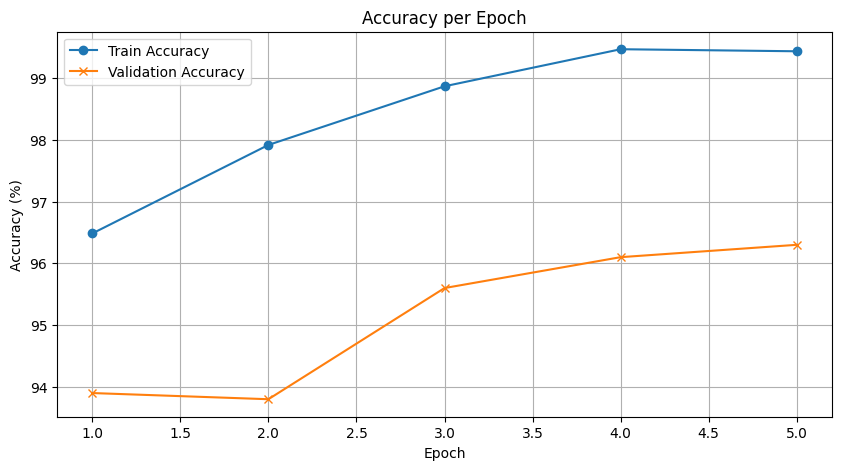

In [31]:
# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), epoch_train_acc, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), epoch_val_acc, label="Validation Accuracy", marker='x')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

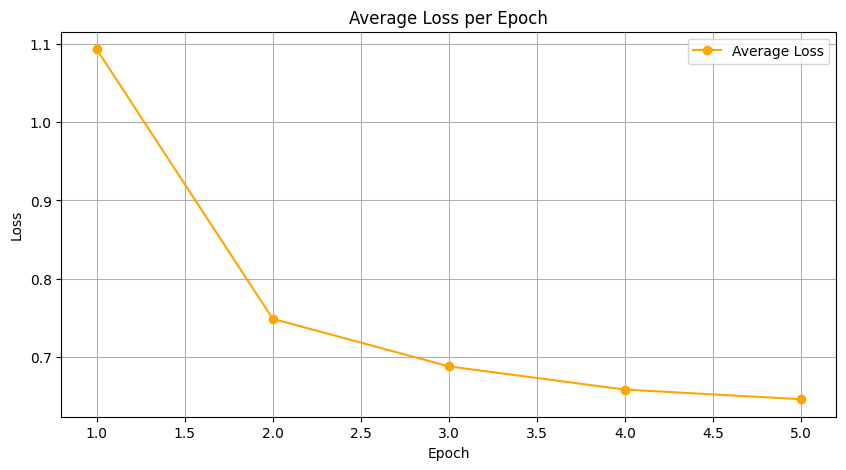

In [32]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), epoch_avg_loss, label="Average Loss", marker='o', color='orange')
plt.title("Average Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# GPU Memory Calculation

This function measures the GPU memory usage separately during the forward pass and the backward pass for a model on a single batch of data.
It clears the CUDA cache, resets memory stats, and prints out how much GPU memory was actually used in each stage, helping diagnose memory bottlenecks during training.

Very useful for debugging and optimizing large models!



In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

def measure_gpu_memory(model, data_loader, device):
    print("\nMeasuring actual GPU memory usage...")

    # Clear CUDA memory
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

    # === Forward Pass Memory ===
    model.eval()
    initial_memory = torch.cuda.memory_allocated(device) / 1e6  # MB

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            break  # only one batch

    forward_peak = torch.cuda.max_memory_allocated(device) / 1e6  # MB
    print(f"Forward Pass Memory Used: {forward_peak - initial_memory:.2f} MB")

    # === Backward Pass Memory ===
    model.train()
    torch.cuda.reset_peak_memory_stats(device)  # reset again

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    initial_memory = torch.cuda.memory_allocated(device) / 1e6  # MB

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        break  # only one batch

    backward_peak = torch.cuda.max_memory_allocated(device) / 1e6  # MB
    print(f"Backward Pass Memory Used: {backward_peak - initial_memory:.2f} MB")


In [34]:
measure_gpu_memory(model, train_loader, device)


Measuring actual GPU memory usage...
Forward Pass Memory Used: 461.37 MB
Backward Pass Memory Used: 3504.24 MB


I implemented a custom ResNet-50 architecture based on the official PyTorch torchvision.models.resnet50 structure and applied transfer learning for a 20-class image classification task on 256×256 images.

Key Steps:
1. Custom Architecture Definition:

Recreated the ResNet-50 network using Bottleneck blocks and the _make_layer method.

Preserved the standard configuration of 3-4-6-3 bottleneck blocks across 4 stages.

Adapted the architecture to output 20 classes directly using nn.Linear(2048, 20).

2. Pretrained Weights Loading (excluding final layer):

Initialized the model with num_classes=20.

Loaded pretrained weights from torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT).

Manually updated the model's state_dict to load all layers except fc, allowing a clean transfer of pretrained features without size mismatch.

3. Input Size Adaptation:

Designed the model to correctly process 256×256 input images, utilizing ResNet’s global average pooling for flexibility in input size.

4. Transfer Learning and Fine-tuning Strategy:

Performed full fine-tuning (trained all layers) using the Adam optimizer with weight decay and label smoothing.

Applied strong data augmentations (RandomResizedCrop, ColorJitter, RandomAffine, RandomErasing) during training to boost generalization.

5. Results Achieved:

Training Accuracy reached 99.43% by epoch 5.

Validation Accuracy achieved 96.30% by epoch 5.

Training Loss reduced steadily from 1.0937 to 0.6456.

GPU Memory Usage:

Forward Pass Memory Used: ~461 MB

Backward Pass Memory Used: ~3504 MB

Peak Reserved Memory during training: 4676 MB.

# I have attached the architecture diagram in the word document and created the architecture using torchviz, please refer ResNet50_Architecture_AparnaSuresh.docx and resnet50_architecture.png as I was not able to paste the image here.